In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2 as cv2
import Augmentor
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma    
)

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)


# config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
# tf.compat.v1.enable_eager_execution(config=config)

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9481699852120199902
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12699417320017408543
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12248931585815578808
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5137629184
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13762578324157786557
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8601120097892071482
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6601636599924714179
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11565175462612903300
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5137629184
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12358210398135002557
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [7]:
tf.config.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Set some parameters
im_width = 256
im_height = 256
border = 5
path_train =  'dataset/waterSmall/train/'
mask_train =  'dataset/waterSmall/mask/'
vpath_train =  'dataset/waterSmall/validation/train/'
vmask_train =  'dataset/waterSmall/validation/mask/'
path_test = '../../mansegimages/test_coast/'
mask_test = '../../mansegimages/mask_test_coast/'

In [9]:
# p = Augmentor.Pipeline(path_train)
# Point to a directory containing ground truth data.
# Images with the same file names will be added as ground truth data
# and augmented in parallel to the original data.
# p.ground_truth(mask_train)
# Add operations to the pipeline as normal:
# p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
# p.flip_left_right(probability=0.5)
# p.zoom_random(probability=1, percentage_area=0.5)
# p.flip_top_bottom(probability=0.5)
# p.sample(5000)

In [10]:
oldpath_train = '../../mansegimages/train_coast/output/'

In [11]:
# Get and resize train images and masks
def get_data(path, maskp, train=True):
    ids = next(os.walk(path))[2]
    size = (int(len(ids)))
    print(size)
    X = np.zeros((size, im_height, im_width, 3), dtype=np.float32)
    if train:
        y = np.zeros((size, im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    tmp = 0
    for n, id_ in enumerate(ids):
        # Load images
        if id_.startswith('train') or 1==1:
            img = load_img(path  + id_, grayscale=False)
        
            x_img = img_to_array(img)
            x_img = resize(x_img, (im_height, im_width, 3), mode='constant', preserve_range=True)
        
            # Load masks
            if train:                
                
                id_ = id_.replace('train_coast_original_water', 'train_coast_water')
                
                mask_path = "{}_groundtruth_(1)_{}".format(path, id_)
                
                iml = load_img(maskp  + id_, grayscale=False)
                mask = img_to_array(iml)
                mask = resize(mask, (im_height, im_width, 1), mode='constant', preserve_range=True)

            # Save images
            
            # X[n, ..., 0] = x_img.squeeze() / 255
            X[tmp] = x_img / 255
            if train:
                y[tmp] = mask / 255
            tmp += 1
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, mask_train, train=True)


1705
Getting and resizing images ... 
Done!


In [12]:
X.shape

(1705, 256, 256, 3)

In [13]:
# Split train and valid
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)
X_train, y_train = X, y

In [14]:
Xx, yy = get_data(vpath_train, vmask_train, train=True)

159
Getting and resizing images ... 
Done!


In [15]:
X_valid, y_valid = Xx, yy

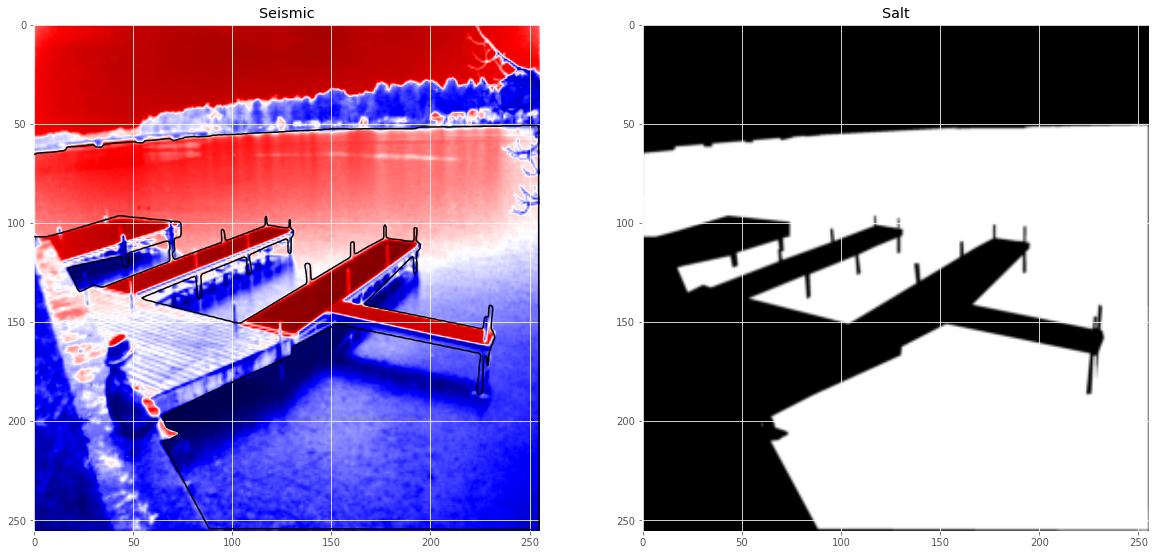

In [16]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

In [17]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [18]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [19]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
def get_unet_256(input_shape=(256, 256, 3),
                 num_classes=1):
    inputs = Input(shape=input_shape)
    # 256

    down0 = Conv2D(32, (3, 3), padding='same')(inputs)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)
    # 128

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 128

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    # 256

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0)

    model = Model(inputs=inputs, outputs=classify)

    # model.compile(optimizer=RMSprop(lr=0.0001), loss=bce_dice_loss, metrics=[dice_coeff])

    return model


Using TensorFlow backend.


In [20]:
from keras.losses import binary_crossentropy
import keras.backend as K


def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [43]:
# input_img = Input((im_height, im_width, 3), name='img')
# model = get_unet(input_img, n_filters=16, dropout=0.4, batchnorm=True)
model = get_unet_256(((im_height, im_width, 3)))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=bce_dice_loss, metrics=[dice_loss,"accuracy","binary_crossentropy"])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_141 (Conv2D)             (None, 256, 256, 32) 896         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_136 (BatchN (None, 256, 256, 32) 128         conv2d_141[0][0]                 
__________________________________________________________________________________________________
activation_136 (Activation)     (None, 256, 256, 32) 0           batch_normalization_136[0][0]    
____________________________________________________________________________________________

In [44]:
callbacks = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-sea.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [45]:
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# tf.compat.v1.enable_eager_execution(config=config)

# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.1
# sess = tf.compat.v1.Session(config=config)  callbacks=callbacks,

In [48]:
results = model.fit(X_train, y_train, batch_size=8, epochs=100,
                    validation_data=(X_valid, y_valid))

Train on 1705 samples, validate on 159 samples
Epoch 1/100
1705/1705 [==============================] - 97s 57ms/step - loss: 1.0848 - dice_loss: 0.6072 - accuracy: 0.6429 - binary_crossentropy: 0.4772 - val_loss: 2.8991 - val_dice_loss: 0.6169 - val_accuracy: 0.2540 - val_binary_crossentropy: 2.2826
Epoch 2/100
1705/1705 [==============================] - 93s 55ms/step - loss: 0.9925 - dice_loss: 0.5613 - accuracy: 0.6753 - binary_crossentropy: 0.4320 - val_loss: 1.1601 - val_dice_loss: 0.5125 - val_accuracy: 0.5725 - val_binary_crossentropy: 0.6481
Epoch 3/100
1705/1705 [==============================] - 94s 55ms/step - loss: 0.9522 - dice_loss: 0.5339 - accuracy: 0.6749 - binary_crossentropy: 0.4182 - val_loss: 2.1394 - val_dice_loss: 0.5175 - val_accuracy: 0.4877 - val_binary_crossentropy: 1.6226
Epoch 4/100
1705/1705 [==============================] - 94s 55ms/step - loss: 0.9420 - dice_loss: 0.5266 - accuracy: 0.6802 - binary_crossentropy: 0.4148 - val_loss: 0.9843 - val_dice_los

Epoch 33/100
1705/1705 [==============================] - 93s 55ms/step - loss: 0.6894 - dice_loss: 0.3739 - accuracy: 0.7052 - binary_crossentropy: 0.3181 - val_loss: 0.9669 - val_dice_loss: 0.4298 - val_accuracy: 0.5965 - val_binary_crossentropy: 0.5379
Epoch 34/100
1705/1705 [==============================] - 94s 55ms/step - loss: 0.6594 - dice_loss: 0.3538 - accuracy: 0.7068 - binary_crossentropy: 0.3061 - val_loss: 0.7884 - val_dice_loss: 0.4206 - val_accuracy: 0.7113 - val_binary_crossentropy: 0.3684
Epoch 35/100
1705/1705 [==============================] - 94s 55ms/step - loss: 0.6495 - dice_loss: 0.3479 - accuracy: 0.7070 - binary_crossentropy: 0.3012 - val_loss: 0.9099 - val_dice_loss: 0.4275 - val_accuracy: 0.6293 - val_binary_crossentropy: 0.4829
Epoch 36/100
1705/1705 [==============================] - 94s 55ms/step - loss: 0.6334 - dice_loss: 0.3381 - accuracy: 0.7095 - binary_crossentropy: 0.2962 - val_loss: 0.7987 - val_dice_loss: 0.3827 - val_accuracy: 0.6598 - val_bina

KeyboardInterrupt: 

NameError: name 'results' is not defined

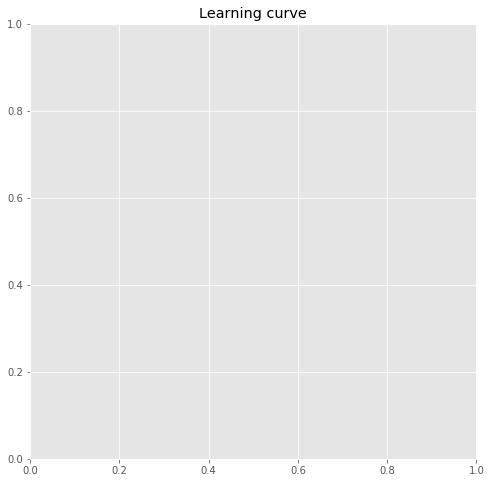

In [49]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")


plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [52]:
# Load best model
#model.save_weights('model-sea.h5')

In [53]:
# Load best model
model.load_weights('model-sea.h5')

In [54]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

159/159 [==============================] - 8s 48ms/step


[0.7711015343666077,
 0.42267030477523804,
 0.7248718738555908,
 0.3486967384815216]

In [69]:
# Predict on train, val and test
# preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid[0:31], verbose=1)

# Threshold predictions
# preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

ResourceExhaustedError:  OOM when allocating tensor with shape[31,32,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node batch_normalization_137/cond/else/_20/batchnorm/mul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_159973]

Function call stack:
keras_scratch_graph


In [56]:
preds_val_t

array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],


In [57]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Origina')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask True')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=15)

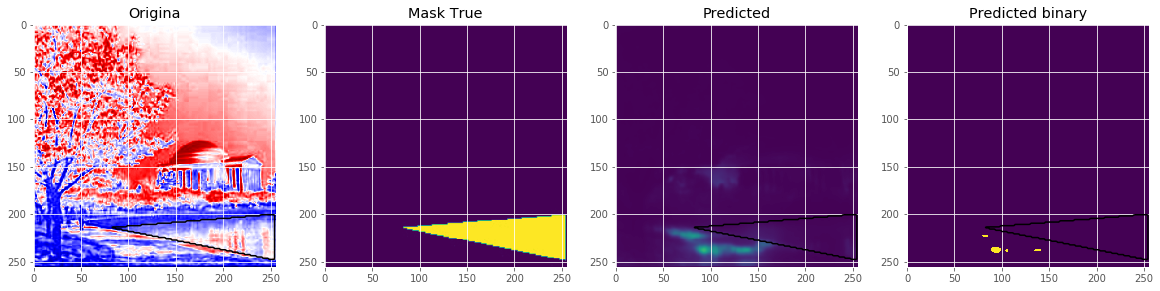

In [67]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=9)